In [21]:
# a Kalman filter depends pretty heavily on different values of Q. What's the best one?

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, signal, optimize

from aberrations import *
from observer import *

In [22]:
vibe_aberrations = make_1D_vibe_data(N=1)
r = 0.06
measurements = make_noisy_data(vibe_aberrations, noise=r)

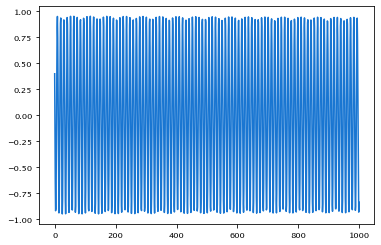

In [23]:
plt.plot(vibe_aberrations)

In [24]:
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=1))
A

array([[ 1.66653516, -0.98985198],
       [ 1.        ,  0.        ]])

In [25]:
steps = vibe_aberrations.size

def kf_to_optimize(q):
    state, A, P, _, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=1))
    Q = np.array([[q, 0], [0, 0]], dtype='float')
    states_freq = np.zeros((steps, state.size))
    for k in range(steps):
        state, P = update(H, P, R, state, measurements[k])
        states_freq[k] = state
        state, P = predict(A, P, Q, state)

    pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()
    last_state = states_freq[-1]
    return np.sqrt(np.mean((pos_freq - vibe_aberrations)**2)), pos_freq, P, P[0][0]/(P[0][0] + R[0][0])


q0 = Q[0][0]
res = optimize.minimize(lambda q: kf_to_optimize(q)[0], [q0], method='Nelder-Mead')

In [26]:
print(q0)
res_base = kf_to_optimize(q0)
res_base[0]

0.0004998152319884834


0.22371547698449754

In [27]:
print(res.x)
res_opt = kf_to_optimize(res.x)
res_opt[0]

[0.31485861]


0.1064354155309507

In [29]:
q_ARE = 0.0561
print(q_ARE)
res_ARE = kf_to_optimize(q_ARE)
res_ARE[0]

0.0561


0.11113694029970417

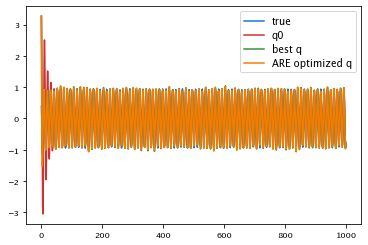

In [30]:
plt.plot(vibe_aberrations, label='true')
plt.plot(res_base[1], label='q0')
plt.plot(res_opt[1], label='best q')
plt.plot(kf_to_optimize(q_ARE)[1], label='ARE optimized q')
plt.legend()

In [31]:
P_base = res_base[2]
P_opt = res_opt[2]
pm, c, pp = P_opt[0][0], P_opt[0][1], P_opt[1][1]
c - A[0][0] * pm * r/(pm + r - A[0][1] * r

array([[0.14484043],
       [0.11179092]])

In [32]:
print(res_opt[2])
P_opt = res_opt[2]
pm, pp = [res_opt[2][i][i] for i in range(2)]
(pm - pp)/pm

P_opt.dot(H.T.dot(np.linalg.inv(H.dot(P_opt.dot(H.T)) + R)))

[[0.47360243 0.07986007]
 [0.07986007 0.0532534 ]]


array([[0.88755673],
       [0.14966212]])

In [33]:
A

array([[ 1.66653516, -0.98985198],
       [ 1.        ,  0.        ]])

In [34]:
print(pp - pm * r / (pm + r)) # relation on p+, p- validated
print(c - A[0][0] * pm * r/(pm + 2*r)) # approximate relation on c, p- validated

5.551115123125783e-17
8.191560214708404e-05


In [35]:
q = res_opt[0]
a1, a2 = A[0][0], A[0][1]
print("exact", pm - (q + a1*(a2*c + a1*pm) + a2*(a1*c + a2*(pm - pm**2/(pm + r))) + (a2*c*(a2*c + a1*pm))/(pm + r) + (a1*pm*(a2*c + a1*pm))/(pm + r)))
print("first", pm - (q + a1*(a2*c + a1*pm) + a2*(a1*c + a2*(pm - pm**2/(pm + r))) - (a2*c*(a2*c + a1*pm))/(pm + r)))
print("second", pm - (q + a1*(a2*c + a1*pm) + a2*(a1*c + a2*(pm - pm**2/(pm + r)))))
print("third",pm - (q + r + 2*a1*a2*c)/(1 - a1**2))
print("fourth",pm - (q + r)/(1 - a1**2))
print("fifth",pm - (q + a1*pm + a2*(a2*(pm - pm**2/(pm + r))) + (a1*pm*(a1*pm))/(pm + r)))
# slightly off even though P is at a steady state

exact -1.6821985985573713
first -0.8421028767669303
second -0.7368877043485882
third 0.4190024931930505
fourth 0.5672454400777963
fifth -1.6417380568477475


In [ ]:
# we're going to just say we expect zero covariance
print("exact", pp - (pm - pm**2/(pm + r)))
# okay we don't expect zero covariance, but let's say we expect zero deviation in the covariance due to Q
# this makes sense because it's an off-diagonal element and q is only on the diagonal?
# so for the sake of optimization with q, we're fine

In [ ]:
# want to check if P is at a steady state.
def plot_P(q):
    state, A, P, _, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=1))
    Q = np.array([[q, 0], [0, 0]], dtype='float')
    pp = np.zeros(steps)
    c = np.zeros(steps)
    pm = np.zeros(steps)
    for k in range(steps):
        state, P = update(H, P, R, state, measurements[k])
        pm[k], c[k], pp[k] = P[0][0], P[0][1], P[1][1]
        state, P = predict(A, P, Q, state)

    plt.plot(np.diff(pp), label='p plus')
    plt.plot(np.diff(pm), label='p minus')
    plt.plot(np.diff(c), label='c')
    plt.legend()
    plt.show()
    
plot_P(res_base[0])
plot_P(res_opt[0])

# well it sure is